cuda
Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
best val epoch: 1
[1/100]: loss_train: 13.333 loss_val 13.379 loss_ts 14.694
[2/100]: loss_train: 13.299 loss_val 13.545 loss_ts 14.833
[3/100]: loss_train: 13.304 loss_val 13.486 loss_ts 14.782
[4/100]: loss_train: 13.305 loss_val 13.476 loss_ts 14.773
[5/100]: loss_train: 13.300 loss_val 13.535 loss_ts 14.824
[6/100]: loss_train: 13.301 loss_val 13.627 loss_ts 14.904
[7/100]: loss_train: 13.300 loss_val 13.594 loss_ts 14.875
[8/100]: loss_train: 13.300 loss_val 13.610 loss_ts 14.888
[9/100]: loss_train: 13.300 loss_val 13.530 loss_t

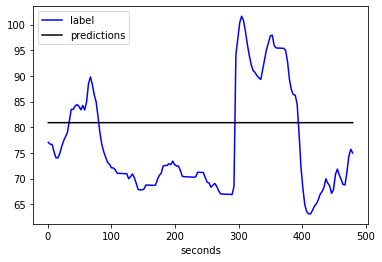

Validation


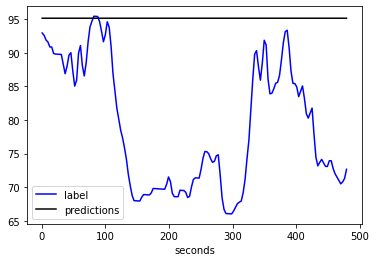

Train


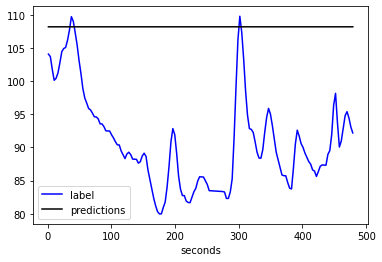

[11/100]: loss_train: 13.299 loss_val 13.553 loss_ts 14.840
[12/100]: loss_train: 13.301 loss_val 13.511 loss_ts 14.804
[13/100]: loss_train: 13.299 loss_val 13.525 loss_ts 14.816
[14/100]: loss_train: 13.300 loss_val 13.493 loss_ts 14.790
best val epoch: 15
[15/100]: loss_train: 13.295 loss_val 13.370 loss_ts 14.708
[16/100]: loss_train: 13.297 loss_val 13.518 loss_ts 14.812
[17/100]: loss_train: 13.297 loss_val 13.497 loss_ts 14.795
[18/100]: loss_train: 13.290 loss_val 13.452 loss_ts 14.766
[19/100]: loss_train: 13.197 loss_val 13.383 loss_ts 14.799
best val epoch: 20
[20/100]: loss_train: 13.352 loss_val 13.302 loss_ts 14.637
Test


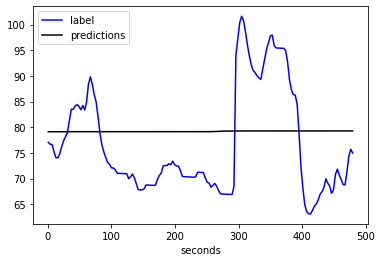

Validation


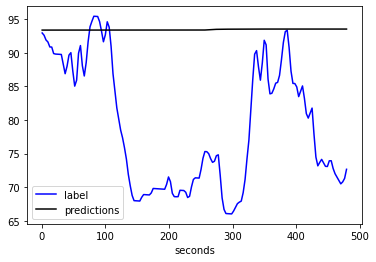

Train


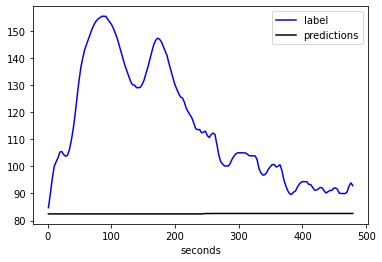

[21/100]: loss_train: 13.303 loss_val 13.487 loss_ts 14.783
[22/100]: loss_train: 13.304 loss_val 13.657 loss_ts 14.929
[23/100]: loss_train: 13.299 loss_val 13.537 loss_ts 14.826
[24/100]: loss_train: 13.300 loss_val 13.601 loss_ts 14.881
[25/100]: loss_train: 13.304 loss_val 13.661 loss_ts 14.934
[26/100]: loss_train: 13.300 loss_val 13.620 loss_ts 14.898
[27/100]: loss_train: 13.299 loss_val 13.530 loss_ts 14.821
[28/100]: loss_train: 13.301 loss_val 13.638 loss_ts 14.914
[29/100]: loss_train: 13.302 loss_val 13.651 loss_ts 14.925
[30/100]: loss_train: 13.301 loss_val 13.651 loss_ts 14.926
Test


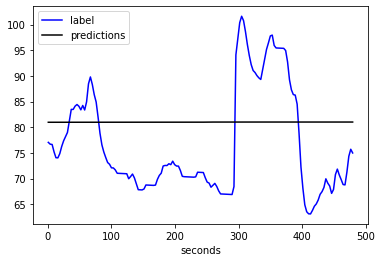

Validation


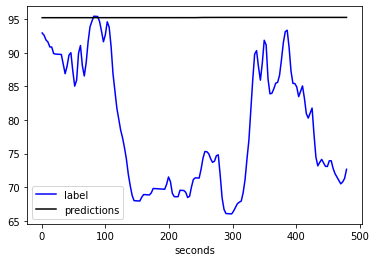

Train


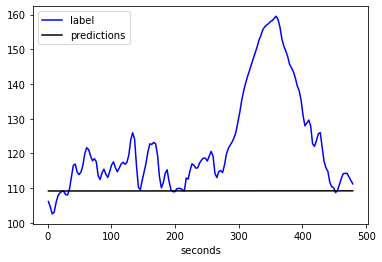

[31/100]: loss_train: 13.293 loss_val 13.605 loss_ts 14.891
best val epoch: 32
[32/100]: loss_train: 13.238 loss_val 13.237 loss_ts 14.657
[33/100]: loss_train: 13.229 loss_val 13.359 loss_ts 14.743
best val epoch: 34
[34/100]: loss_train: 13.120 loss_val 12.992 loss_ts 14.371
[35/100]: loss_train: 13.113 loss_val 13.040 loss_ts 14.613
[36/100]: loss_train: 13.101 loss_val 13.048 loss_ts 14.638
[37/100]: loss_train: 13.113 loss_val 12.999 loss_ts 14.254
best val epoch: 38
[38/100]: loss_train: 13.097 loss_val 12.847 loss_ts 14.360
[39/100]: loss_train: 13.110 loss_val 12.938 loss_ts 14.574
[40/100]: loss_train: 13.215 loss_val 12.919 loss_ts 14.528
Test


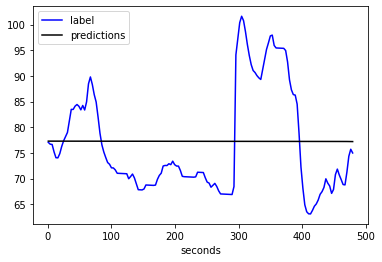

Validation


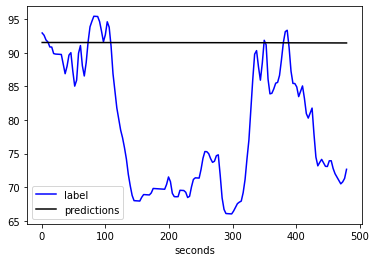

Train


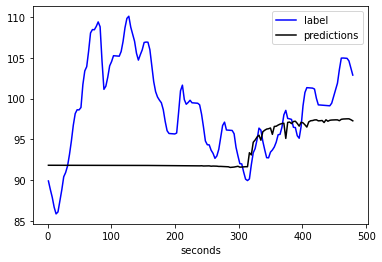

[41/100]: loss_train: 13.028 loss_val 12.882 loss_ts 14.476
best val epoch: 42
[42/100]: loss_train: 13.031 loss_val 12.762 loss_ts 14.288
[43/100]: loss_train: 13.305 loss_val 12.982 loss_ts 14.582
[44/100]: loss_train: 13.056 loss_val 12.950 loss_ts 14.490
best val epoch: 45
[45/100]: loss_train: 12.986 loss_val 12.751 loss_ts 14.433
[46/100]: loss_train: 12.972 loss_val 12.773 loss_ts 14.350
[47/100]: loss_train: 12.926 loss_val 12.762 loss_ts 14.283
best val epoch: 48
[48/100]: loss_train: 12.917 loss_val 12.668 loss_ts 14.345
[49/100]: loss_train: 13.000 loss_val 12.780 loss_ts 14.612
[50/100]: loss_train: 12.959 loss_val 12.739 loss_ts 14.371
Test


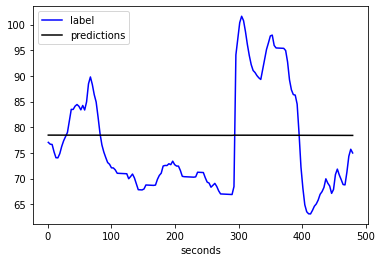

Validation


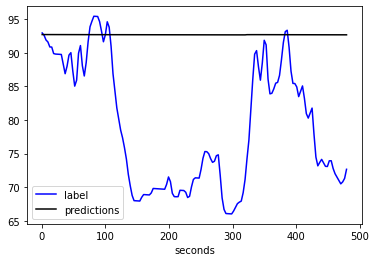

Train


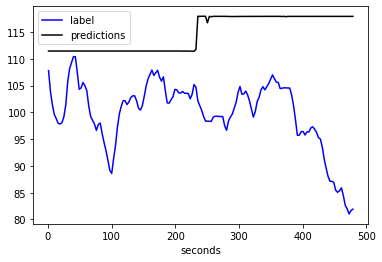

[51/100]: loss_train: 12.851 loss_val 12.700 loss_ts 14.290
best val epoch: 52
[52/100]: loss_train: 12.728 loss_val 12.591 loss_ts 14.389
[53/100]: loss_train: 13.095 loss_val 13.379 loss_ts 14.183
[54/100]: loss_train: 12.915 loss_val 13.486 loss_ts 14.796
[55/100]: loss_train: 12.774 loss_val 13.735 loss_ts 14.844
[56/100]: loss_train: 13.007 loss_val 13.062 loss_ts 14.460
[57/100]: loss_train: 13.329 loss_val 12.845 loss_ts 14.550
[58/100]: loss_train: 13.340 loss_val 13.544 loss_ts 14.720
[59/100]: loss_train: 13.315 loss_val 13.745 loss_ts 15.005
[60/100]: loss_train: 13.309 loss_val 13.451 loss_ts 14.752
Test


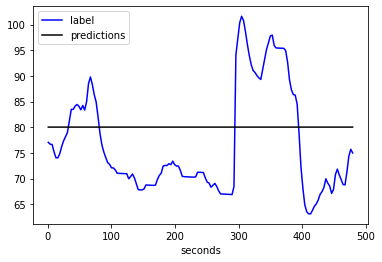

Validation


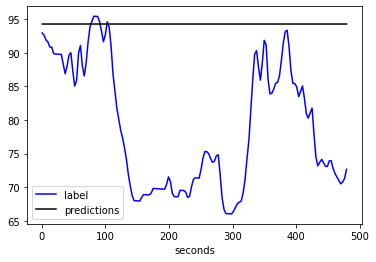

Train


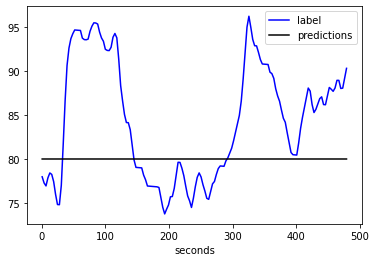

[61/100]: loss_train: 13.305 loss_val 13.470 loss_ts 14.767
[62/100]: loss_train: 13.299 loss_val 13.642 loss_ts 14.916
[63/100]: loss_train: 13.299 loss_val 13.734 loss_ts 14.996
[64/100]: loss_train: 13.290 loss_val 13.616 loss_ts 14.900
[65/100]: loss_train: 13.296 loss_val 13.649 loss_ts 14.937
[66/100]: loss_train: 13.343 loss_val 13.851 loss_ts 15.099
[67/100]: loss_train: 13.303 loss_val 13.553 loss_ts 14.840
[68/100]: loss_train: 13.304 loss_val 13.610 loss_ts 14.888
[69/100]: loss_train: 13.313 loss_val 13.700 loss_ts 14.967
[70/100]: loss_train: 13.302 loss_val 13.620 loss_ts 14.898
Test


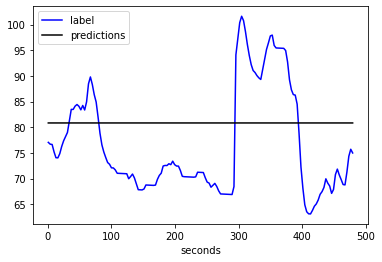

Validation


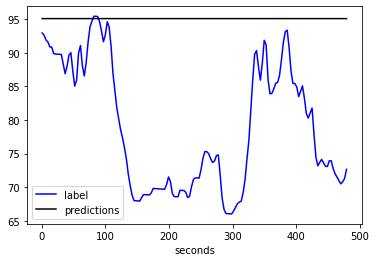

Train


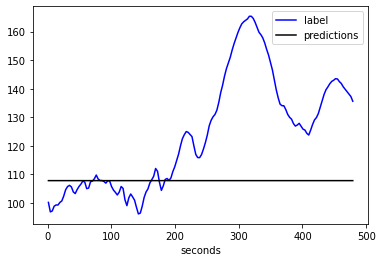

[71/100]: loss_train: 13.298 loss_val 13.520 loss_ts 14.812
[72/100]: loss_train: 13.297 loss_val 13.526 loss_ts 14.816
[73/100]: loss_train: 13.299 loss_val 13.625 loss_ts 14.902
[74/100]: loss_train: 13.305 loss_val 13.686 loss_ts 14.955
[75/100]: loss_train: 13.308 loss_val 13.709 loss_ts 14.974
[76/100]: loss_train: 13.299 loss_val 13.661 loss_ts 14.932
[77/100]: loss_train: 13.303 loss_val 13.695 loss_ts 14.962
[78/100]: loss_train: 13.298 loss_val 13.669 loss_ts 14.940
[79/100]: loss_train: 13.290 loss_val 13.561 loss_ts 14.847
[80/100]: loss_train: 13.290 loss_val 13.587 loss_ts 14.868
Test


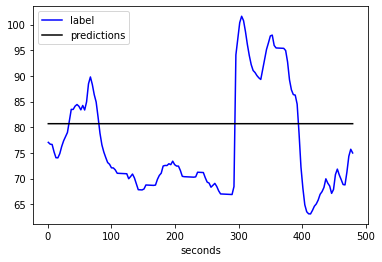

Validation


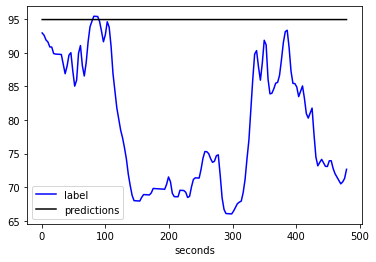

Train


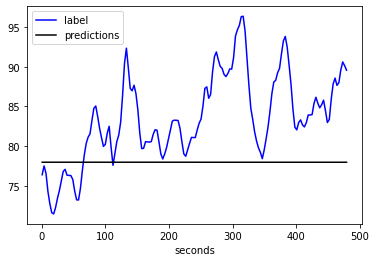

[81/100]: loss_train: 13.292 loss_val 13.629 loss_ts 14.905
[82/100]: loss_train: 13.296 loss_val 13.673 loss_ts 14.943
[83/100]: loss_train: 13.294 loss_val 13.654 loss_ts 14.926
[84/100]: loss_train: 13.296 loss_val 13.675 loss_ts 14.945
[85/100]: loss_train: 13.288 loss_val 13.513 loss_ts 14.805
[86/100]: loss_train: 13.288 loss_val 13.584 loss_ts 14.866
[87/100]: loss_train: 13.292 loss_val 13.648 loss_ts 14.922
[88/100]: loss_train: 13.287 loss_val 13.595 loss_ts 14.875
[89/100]: loss_train: 13.299 loss_val 13.705 loss_ts 14.971
[90/100]: loss_train: 13.300 loss_val 13.711 loss_ts 14.976
Test


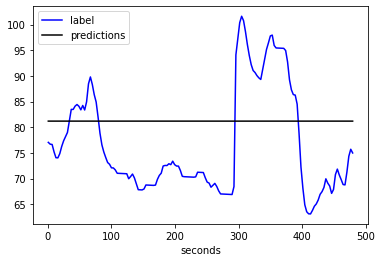

Validation


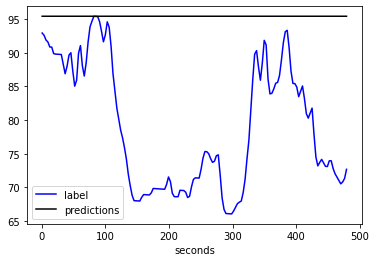

Train


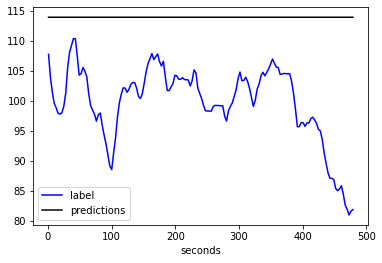

[91/100]: loss_train: 13.288 loss_val 13.622 loss_ts 14.899
[92/100]: loss_train: 13.292 loss_val 13.656 loss_ts 14.928
[93/100]: loss_train: 13.285 loss_val 13.516 loss_ts 14.808
[94/100]: loss_train: 13.286 loss_val 13.596 loss_ts 14.877
[95/100]: loss_train: 13.285 loss_val 13.500 loss_ts 14.794
[96/100]: loss_train: 13.284 loss_val 13.581 loss_ts 14.863
[97/100]: loss_train: 13.284 loss_val 13.597 loss_ts 14.877
[98/100]: loss_train: 13.287 loss_val 13.641 loss_ts 14.915
[99/100]: loss_train: 13.281 loss_val 13.595 loss_ts 14.875
[100/100]: loss_train: 13.278 loss_val 13.558 loss_ts 14.844
Test


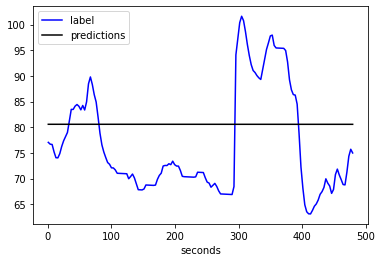

Validation


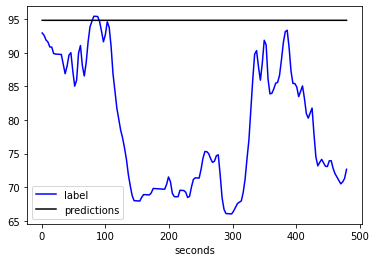

Train


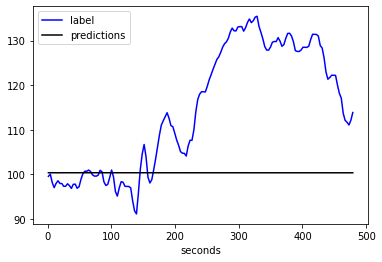

going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
best val epoch: 1
[1/100]: loss_train: 14.098 loss_val 13.367 loss_ts 11.143
[2/100]: loss_train: 14.052 loss_val 13.597 loss_ts 11.135
[3/100]: loss_train: 14.069 loss_val 13.792 loss_ts 11.193
[4/100]: loss_train: 14.055 loss_val 13.673 loss_ts 11.151
[5/100]: loss_train: 14.085 loss_val 13.395 loss_ts 11.133
[6/100]: loss_train: 14.052 loss_val 13.597 loss_ts 11.135
[7/100]: loss_train: 14.05

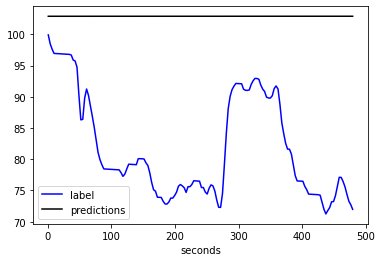

Validation


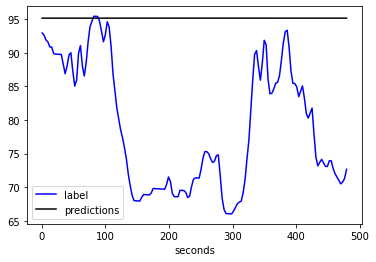

Train


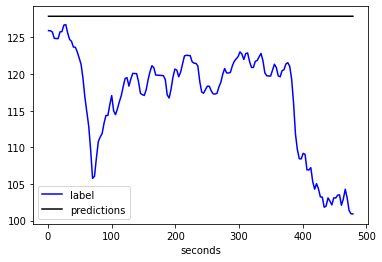

[11/100]: loss_train: 14.051 loss_val 13.578 loss_ts 11.131
[12/100]: loss_train: 14.051 loss_val 13.622 loss_ts 11.138
[13/100]: loss_train: 14.051 loss_val 13.647 loss_ts 11.143
[14/100]: loss_train: 14.033 loss_val 13.494 loss_ts 11.103
best val epoch: 15
[15/100]: loss_train: 13.966 loss_val 13.316 loss_ts 11.032
[16/100]: loss_train: 13.960 loss_val 13.335 loss_ts 11.034
[17/100]: loss_train: 13.923 loss_val 13.408 loss_ts 11.060
[18/100]: loss_train: 14.051 loss_val 13.728 loss_ts 11.165
[19/100]: loss_train: 14.062 loss_val 13.473 loss_ts 11.121
[20/100]: loss_train: 14.072 loss_val 13.806 loss_ts 11.198
Test


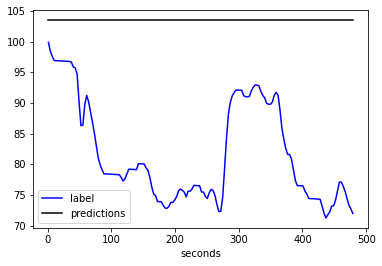

Validation


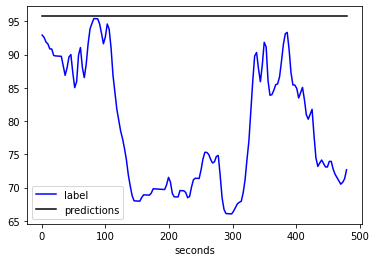

Train


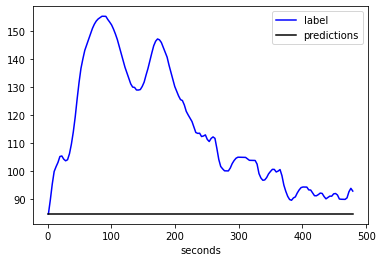

[21/100]: loss_train: 14.062 loss_val 13.472 loss_ts 11.121
[22/100]: loss_train: 14.053 loss_val 13.640 loss_ts 11.143
[23/100]: loss_train: 14.061 loss_val 13.733 loss_ts 11.170
[24/100]: loss_train: 14.054 loss_val 13.533 loss_ts 11.124
[25/100]: loss_train: 14.052 loss_val 13.589 loss_ts 11.133
[26/100]: loss_train: 14.052 loss_val 13.578 loss_ts 11.131
[27/100]: loss_train: 14.058 loss_val 13.703 loss_ts 11.160
[28/100]: loss_train: 14.052 loss_val 13.634 loss_ts 11.141
[29/100]: loss_train: 14.047 loss_val 13.620 loss_ts 11.135
[30/100]: loss_train: 14.008 loss_val 13.433 loss_ts 11.071
Test


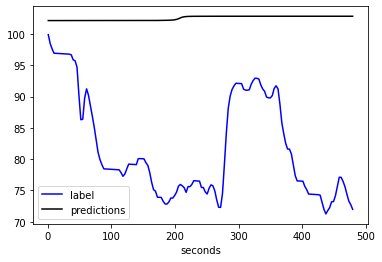

Validation


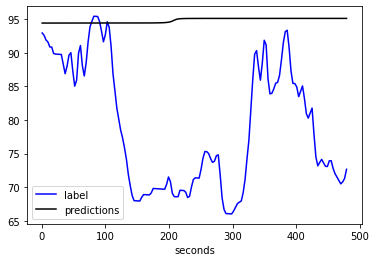

Train


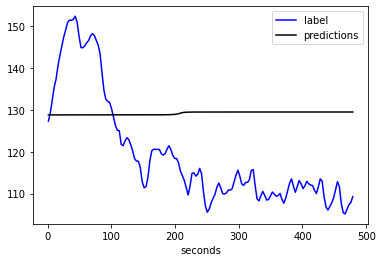

best val epoch: 31
[31/100]: loss_train: 13.879 loss_val 13.160 loss_ts 11.005
best val epoch: 32
[32/100]: loss_train: 13.865 loss_val 12.979 loss_ts 11.043
[33/100]: loss_train: 13.866 loss_val 13.178 loss_ts 11.045
[34/100]: loss_train: 13.865 loss_val 13.197 loss_ts 11.090
[35/100]: loss_train: 13.860 loss_val 13.042 loss_ts 11.053
[36/100]: loss_train: 13.860 loss_val 13.047 loss_ts 11.066
[37/100]: loss_train: 13.864 loss_val 12.992 loss_ts 11.053
[38/100]: loss_train: 13.863 loss_val 13.075 loss_ts 11.066
[39/100]: loss_train: 13.861 loss_val 13.098 loss_ts 11.058
[40/100]: loss_train: 13.860 loss_val 13.075 loss_ts 11.049
Test


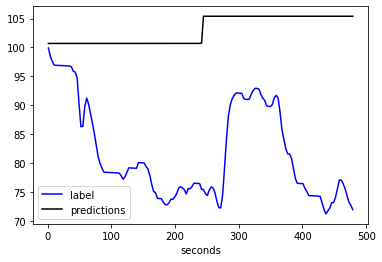

Validation


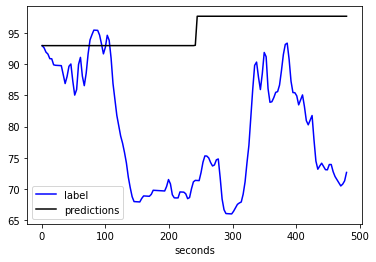

Train


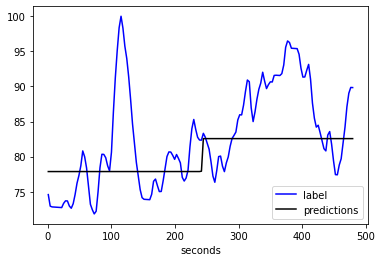

[41/100]: loss_train: 13.858 loss_val 13.059 loss_ts 11.062
[42/100]: loss_train: 13.859 loss_val 13.092 loss_ts 11.082
[43/100]: loss_train: 13.859 loss_val 13.103 loss_ts 11.072
[44/100]: loss_train: 13.859 loss_val 13.086 loss_ts 11.082
[45/100]: loss_train: 13.859 loss_val 13.038 loss_ts 11.043
[46/100]: loss_train: 13.859 loss_val 13.087 loss_ts 11.077
[47/100]: loss_train: 13.859 loss_val 13.059 loss_ts 11.079
[48/100]: loss_train: 13.860 loss_val 13.089 loss_ts 11.091
[49/100]: loss_train: 13.860 loss_val 13.098 loss_ts 11.086
[50/100]: loss_train: 13.858 loss_val 13.043 loss_ts 11.055
Test


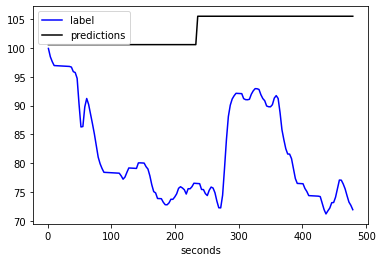

Validation


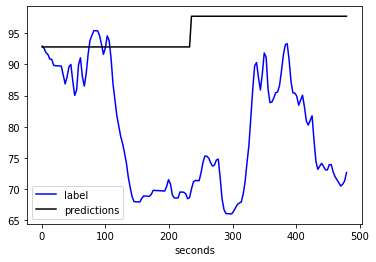

Train


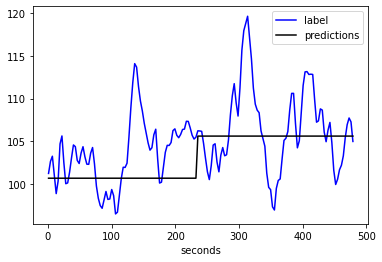

[51/100]: loss_train: 13.859 loss_val 13.028 loss_ts 11.051
[52/100]: loss_train: 13.859 loss_val 13.071 loss_ts 11.078
[53/100]: loss_train: 13.859 loss_val 13.073 loss_ts 11.078
[54/100]: loss_train: 13.858 loss_val 13.046 loss_ts 11.070
[55/100]: loss_train: 13.859 loss_val 13.027 loss_ts 11.055
[56/100]: loss_train: 13.859 loss_val 13.031 loss_ts 11.051
[57/100]: loss_train: 13.858 loss_val 13.055 loss_ts 11.069
[58/100]: loss_train: 13.859 loss_val 13.106 loss_ts 11.078
[59/100]: loss_train: 13.859 loss_val 13.084 loss_ts 11.081
[60/100]: loss_train: 13.858 loss_val 13.066 loss_ts 11.069
Test


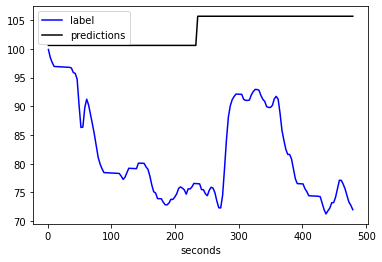

Validation


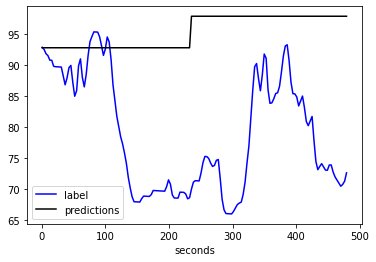

Train


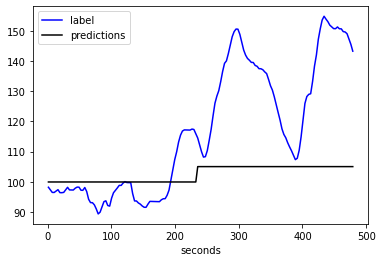

[61/100]: loss_train: 13.858 loss_val 13.045 loss_ts 11.067
[62/100]: loss_train: 13.858 loss_val 13.042 loss_ts 11.061
[63/100]: loss_train: 13.859 loss_val 13.066 loss_ts 11.076
[64/100]: loss_train: 13.859 loss_val 13.029 loss_ts 11.058
[65/100]: loss_train: 13.859 loss_val 13.059 loss_ts 11.075
[66/100]: loss_train: 13.859 loss_val 13.062 loss_ts 11.076
[67/100]: loss_train: 13.859 loss_val 13.079 loss_ts 11.078
[68/100]: loss_train: 13.859 loss_val 13.074 loss_ts 11.083
[69/100]: loss_train: 13.858 loss_val 13.057 loss_ts 11.070
[70/100]: loss_train: 13.859 loss_val 13.031 loss_ts 11.046
Test


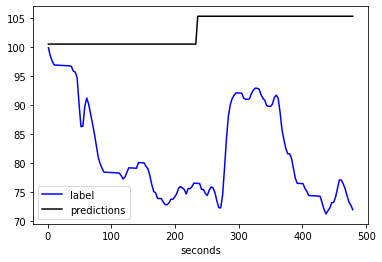

Validation


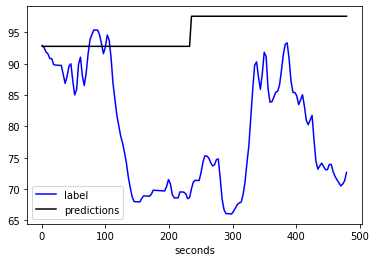

Train


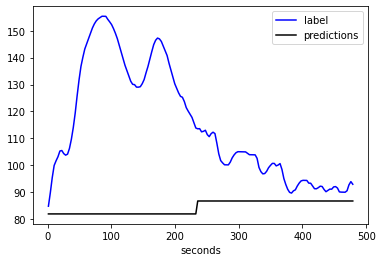

[71/100]: loss_train: 13.858 loss_val 13.061 loss_ts 11.068
[72/100]: loss_train: 13.859 loss_val 13.073 loss_ts 11.082
[73/100]: loss_train: 13.858 loss_val 13.039 loss_ts 11.060
[74/100]: loss_train: 13.859 loss_val 13.058 loss_ts 11.079
[75/100]: loss_train: 13.860 loss_val 13.086 loss_ts 11.093
[76/100]: loss_train: 13.860 loss_val 13.089 loss_ts 11.086
[77/100]: loss_train: 13.858 loss_val 13.053 loss_ts 11.063
[78/100]: loss_train: 13.859 loss_val 13.039 loss_ts 11.069
[79/100]: loss_train: 13.859 loss_val 13.066 loss_ts 11.079
[80/100]: loss_train: 13.858 loss_val 13.042 loss_ts 11.061
Test


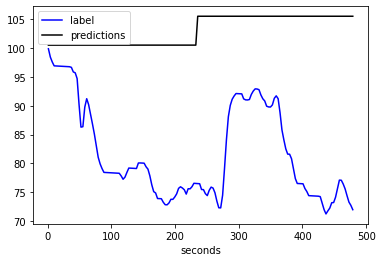

Validation


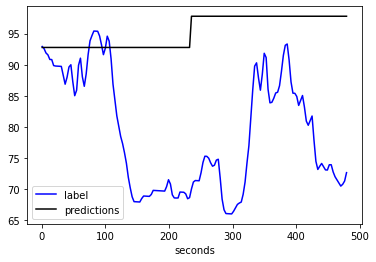

Train


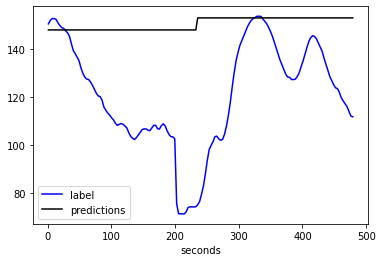

[81/100]: loss_train: 13.858 loss_val 13.040 loss_ts 11.061
[82/100]: loss_train: 13.858 loss_val 13.054 loss_ts 11.071
[83/100]: loss_train: 13.859 loss_val 13.068 loss_ts 11.086
[84/100]: loss_train: 13.860 loss_val 13.079 loss_ts 11.089
[85/100]: loss_train: 13.860 loss_val 13.082 loss_ts 11.092
[86/100]: loss_train: 13.859 loss_val 13.068 loss_ts 11.075
[87/100]: loss_train: 13.858 loss_val 13.046 loss_ts 11.064
[88/100]: loss_train: 13.858 loss_val 13.054 loss_ts 11.072
[89/100]: loss_train: 13.859 loss_val 13.062 loss_ts 11.081
[90/100]: loss_train: 13.858 loss_val 13.051 loss_ts 11.062
Test


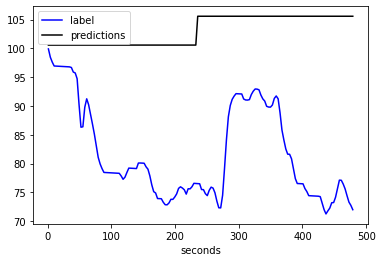

Validation


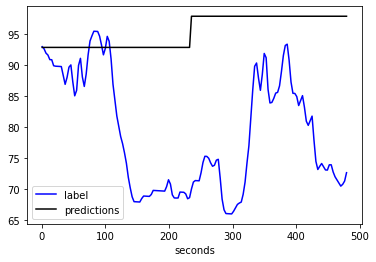

Train


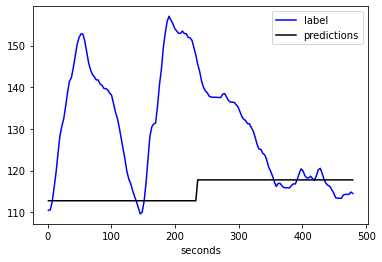

[91/100]: loss_train: 13.862 loss_val 13.143 loss_ts 11.088
[92/100]: loss_train: 13.859 loss_val 13.100 loss_ts 11.073
[93/100]: loss_train: 13.859 loss_val 13.110 loss_ts 11.077
[94/100]: loss_train: 13.860 loss_val 13.094 loss_ts 11.085
[95/100]: loss_train: 13.859 loss_val 13.059 loss_ts 11.074
[96/100]: loss_train: 13.859 loss_val 13.075 loss_ts 11.082
[97/100]: loss_train: 13.858 loss_val 13.059 loss_ts 11.073
[98/100]: loss_train: 13.859 loss_val 13.080 loss_ts 11.080
[99/100]: loss_train: 13.859 loss_val 13.074 loss_ts 11.081
[100/100]: loss_train: 13.858 loss_val 13.037 loss_ts 11.059
Test


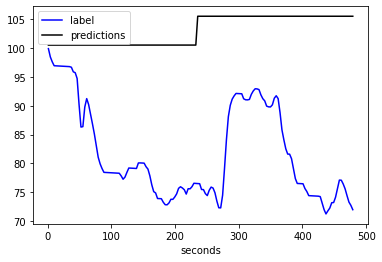

Validation


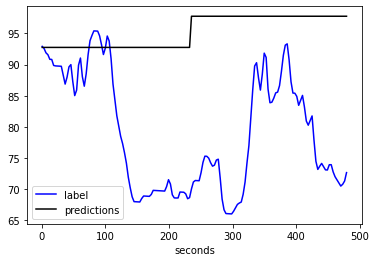

Train


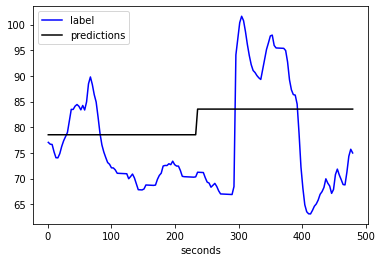

going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
best val epoch: 1
[1/100]: loss_train: 13.390 loss_val 13.417 loss_ts 15.555
[2/100]: loss_train: 13.381 loss_val 13.599 loss_ts 15.601
[3/100]: loss_train: 13.379 loss_val 13.488 loss_ts 15.569
[4/100]: loss_train: 13.379 loss_val 13.498 loss_ts 15.572
[5/100]: loss_train: 13.378 loss_val 13.546 loss_ts 15.584
[6/100]: loss_train: 13.379 loss_val 13.556 loss_ts 15.587
[7/100]: loss_train: 13.37

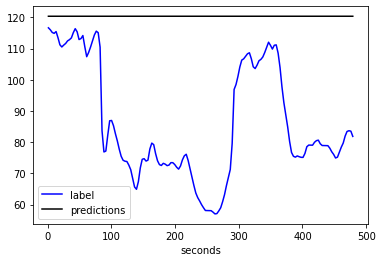

Validation


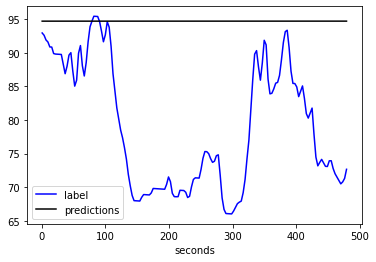

Train


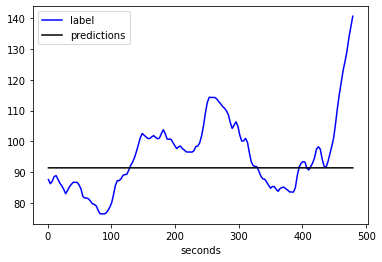

[11/100]: loss_train: 13.378 loss_val 13.545 loss_ts 15.583
[12/100]: loss_train: 13.379 loss_val 13.475 loss_ts 15.566
[13/100]: loss_train: 13.373 loss_val 13.480 loss_ts 15.567
best val epoch: 14
[14/100]: loss_train: 13.362 loss_val 13.416 loss_ts 15.552
best val epoch: 15
[15/100]: loss_train: 13.318 loss_val 13.378 loss_ts 15.541
best val epoch: 16
[16/100]: loss_train: 13.300 loss_val 13.233 loss_ts 15.508
best val epoch: 17
[17/100]: loss_train: 13.248 loss_val 13.082 loss_ts 15.486
[18/100]: loss_train: 13.237 loss_val 13.106 loss_ts 15.482
best val epoch: 19
[19/100]: loss_train: 13.240 loss_val 12.919 loss_ts 15.477
best val epoch: 20
[20/100]: loss_train: 13.233 loss_val 12.917 loss_ts 15.476
Test


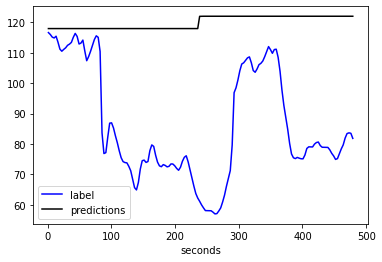

Validation


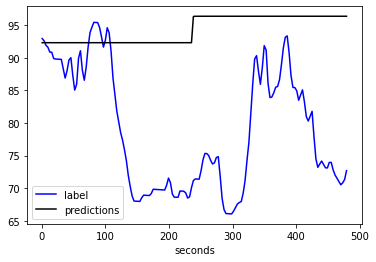

Train


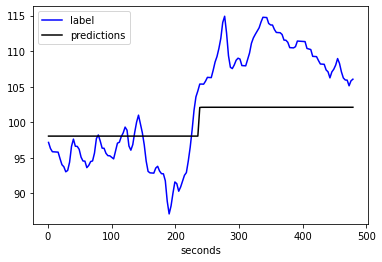

[21/100]: loss_train: 13.235 loss_val 12.919 loss_ts 15.476
[22/100]: loss_train: 13.223 loss_val 12.958 loss_ts 15.472
[23/100]: loss_train: 13.220 loss_val 12.996 loss_ts 15.474
[24/100]: loss_train: 13.223 loss_val 12.955 loss_ts 15.474
[25/100]: loss_train: 13.220 loss_val 13.012 loss_ts 15.477
[26/100]: loss_train: 13.230 loss_val 13.049 loss_ts 15.490
[27/100]: loss_train: 13.226 loss_val 12.983 loss_ts 15.471
[28/100]: loss_train: 13.226 loss_val 13.019 loss_ts 15.486
[29/100]: loss_train: 13.220 loss_val 12.983 loss_ts 15.474
[30/100]: loss_train: 13.222 loss_val 13.036 loss_ts 15.482
Test


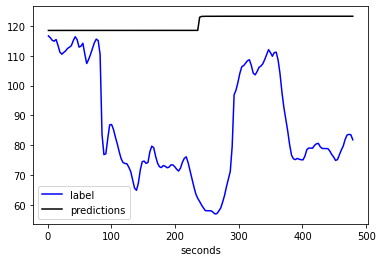

Validation


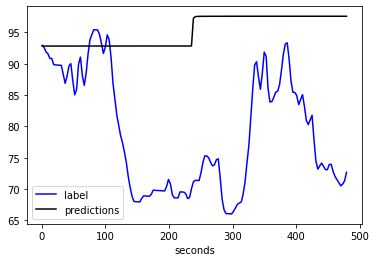

Train


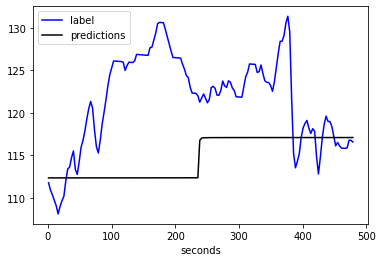

[31/100]: loss_train: 13.220 loss_val 13.052 loss_ts 15.479
[32/100]: loss_train: 13.221 loss_val 13.022 loss_ts 15.479
[33/100]: loss_train: 13.219 loss_val 13.024 loss_ts 15.477
[34/100]: loss_train: 13.222 loss_val 12.988 loss_ts 15.471
[35/100]: loss_train: 13.220 loss_val 12.986 loss_ts 15.472
[36/100]: loss_train: 13.220 loss_val 13.022 loss_ts 15.479
[37/100]: loss_train: 13.222 loss_val 13.045 loss_ts 15.482
[38/100]: loss_train: 13.232 loss_val 12.981 loss_ts 15.461
[39/100]: loss_train: 13.222 loss_val 13.029 loss_ts 15.472


In [ ]:

#%%
import torch

args = {
    'epoch_num': 100,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'batch_size': 5,     # Mini-batch size. 600
    'batch_test': 5,     # size of test batch
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

dataset_name = "PAMAP2"
model_type = "AttentionTransformer"
#"OurConvLSTM", "AttentionTransformer", "DeepConvLSTM", "CnnIMU", FCNN

val_sub = 4
for ts_sub in [7,1,3,5,0]:#2,6]:#[6,7,2,0,1,3,5]:


  ! pip install wget
  import os
  import torch
  import pandas as pd
  import numpy as np
  import torch
  from torch import nn


  ssh_config = """
  Host github.com
    IdentityFile ~/.ssh/github.pem
    User davipeag
    StrictHostKeyChecking no
  """

  if os.name == 'nt':
    base_path = ""
    REPO_DIR = "."
    STORE_DIR ="." 
    print("Windows")
  else:
    print("Unix-like")
    REPO_DIR = "/tmp/HeartRateRegression"
    from google.colab import drive
    drive.mount('/content/drive')
    GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
    DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
    STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
    !mkdir ~/.ssh
    !cp -u {GIT_PATH} ~/.ssh/
    !chmod u=rw,g=,o= ~/.ssh/github.pem
    !echo "{ssh_config}" > ~/.ssh/config
    !chmod u=rw,g=,o= ~/.ssh/config
    ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
    ! (cd {REPO_DIR} && git pull )
    import sys
    sys.path.append(REPO_DIR)


  def git_push():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      ! (cd {REPO_DIR} && git add . && git commit -m "from colab" && git push)

  def git_pull():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      
    
  git_push()



  from data_utils import (
      Pamap2Handler, cross_validation_split)

  from default_utils import DefaultPamapPreprocessing, FcPamapPreprocessing
  from preprocessing_utils import (OurConvLstmToAttentionFormat, OurConvLstmToCnnImuFormat)

  from models_utils import OurConvLstmDataset, make_loader, reset_seeds
  from models_utils import DatasetXY

  from default_utils import TrainOurConvLSTM, TrainXY
  from default_utils import make_our_conv_lstm, make_attention_transormer_model, make_fcnn
  from torch import nn



  reset_seeds()

  ##%%

  dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))

  dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8]]
  df_full = pd.concat(dfs)

  preprocessing_options = {
      "OurConvLSTM": DefaultPamapPreprocessing(ts_count = 300, donwsampling_ratio = 1),
      "AttentionTransformer": DefaultPamapPreprocessing(
        ts_count = 300, donwsampling_ratio = 1, last_transformer=OurConvLstmToAttentionFormat()),
      "DeepConvLSTM": DefaultPamapPreprocessing(last_transformer=OurConvLstmToCnnImuFormat()),
      "CnnIMU": DefaultPamapPreprocessing(last_transformer=OurConvLstmToCnnImuFormat()),
      "FCNN": FcPamapPreprocessing(),
  }
  preprocessor =preprocessing_options[model_type]

  ##%%

  preprocessor.transformers.fit(df_full)
  xy_tr, xy_val, xy_ts = cross_validation_split(dfs, preprocessor.transformers, preprocessor.transformers_ts, preprocessor.transformers_ts, val_sub, ts_sub)

  del dfs
  del df_full

  dataset_cls_options = {
      "OurConvLSTM": OurConvLstmDataset,
      "AttentionTransformer": DatasetXY,
      "DeepConvLSTM": DatasetXY,
      "CnnIMU": DatasetXY,
      "FCNN": DatasetXY,
  }


  dataset_cls = dataset_cls_options[model_type]

  loader_tr = make_loader(xy_tr, dataset_cls, batch_size=args["batch_size"], shuffle=True)
  loader_val = make_loader(xy_val, dataset_cls, batch_size=args["batch_test"],shuffle=False)
  loader_ts = make_loader(xy_ts, dataset_cls, batch_size=args["batch_test"], shuffle=False)

  # #%%
  # x,y = loader_tr.__iter__().__next__()
  # x.shape, y.shape

  ##%%
  from default_utils import make_cnn_imu2
  from default_utils import make_deep_conv_lstm


  net_options = {
      "OurConvLSTM": lambda : make_our_conv_lstm(40,1,False),
      "AttentionTransformer": lambda: make_attention_transormer_model(args["device"]),
      "DeepConvLSTM": lambda : make_deep_conv_lstm(),
      "CnnIMU": lambda : make_cnn_imu2(),
      "FCNN": lambda : make_fcnn()
  }

  net = net_options[model_type]().to(args["device"])
  criterion = nn.L1Loss().to(args["device"]) 
  optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                              weight_decay=args["weight_decay"])

  ##%%


  basic_training_parameters = {
      "net": net,
      "criterion": criterion,
      "optimizer": optimizer,
      "loader_tr": loader_tr,
      "loader_val": loader_val,
      "loader_ts": loader_ts,
      "normdz": preprocessor.normdz,
      "ztransformer": preprocessor.ztransformer,
      "device": args["device"]
  }


  trainer_options = {
      "OurConvLSTM": lambda : TrainOurConvLSTM(**basic_training_parameters),
      "AttentionTransformer": lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: x[:,1, 0, -1].reshape(-1,1)
      ),
      "CnnIMU":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: np.mean(x[:,0,200:300, 0], axis=1).reshape(-1,1)
      ),
      "DeepConvLSTM":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: np.mean(x[:,0,200:300, 0], axis=1).reshape(-1,1)
      ),
      "FCNN":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: x[:,0, 0].reshape(-1,1)
      ), 

  }

  trainer = trainer_options[model_type]()


  run_output = trainer.train_epochs(args["epoch_num"])


  #%%

  state_dict_name = f"trained_models/{model_type}ts_{ts_sub}_val_{val_sub}.pkl"
  torch.save(run_output["best_val_model"], os.path.join(STORE_DIR, state_dict_name))

  git_push()


# %%
